# 

In [1]:
import numpy as np
import math
import torch
import torchvision.transforms as T
from decord import VideoReader, cpu
from PIL import Image
from torchvision.transforms.functional import InterpolationMode
from transformers import AutoModel, AutoTokenizer
import gc


import requests
import validators 
import urllib.parse

from PIL import Image
import requests
from io import BytesIO

/home/ubuntu/anaconda3/envs/sandbox/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [219]:
import sys
sys.version

'3.10.19 (main, Oct 21 2025, 16:43:05) [GCC 11.2.0]'

In [220]:
import decord


In [171]:
MAX_IMAGE_SIZE = 2048
def resize_for_saving(img, max_image_size=MAX_IMAGE_SIZE):
    o_width, o_height = img.size
        
    
    if o_width > max_image_size and o_width > o_height:
        new_width = max_image_size
        new_height = int((max_image_size * o_height) / o_width)
        return img.resize((new_width, new_height), Image.Resampling.LANCZOS)
    elif o_height > max_image_size and o_height > o_width:
        new_height = max_image_size
        new_width = int((max_image_size * o_width) / o_height)
        return img.resize((new_width, new_height), Image.Resampling.LANCZOS)

    return img
        

In [221]:


def load_image(image_file):
    image = Image.open(image_file).convert('RGB')
    image = resize_for_saving(image, max_image_size=MAX_IMAGE_SIZE)
    return image

def load_image_from_url(image_url):
    headers = {
    "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7)"}
    
    response = requests.get(image_url, headers=headers)
    image = Image.open(BytesIO(response.content)).convert('RGB')
    image = resize_for_saving(image, max_image_size=MAX_IMAGE_SIZE)
    return image


def create_pixel_values(image, input_size=448, max_num=12):
    transform = build_transform(input_size=input_size)
    images = dynamic_preprocess(image, image_size=input_size, use_thumbnail=True, max_num=max_num)
    pixel_values = [transform(image) for image in images]
    pixel_values = torch.stack(pixel_values)
    return pixel_values


def load_image_no_db(image_file, input_size=448, max_num=12):
    image = load_image(image_file)
    return create_pixel_values(image, input_size=input_size, max_num=max_num)

def load_image_from_url_no_db(image_url, input_size=448, max_num=12):
    image = load_image_from_url(image_url)
    return create_pixel_values(image, input_size=input_size, max_num=max_num)

    
    

    


In [ ]:


def feedback_from_url(image_url, question="Please describe the image in as much detail as possible"):

    response = prompt_from_url(image_url, question=question)
    feedback = input("Press enter if you approve of the response otherwise provided informative feedback")
    return response, feedback

In [ ]:
def prompt_from_url(image_url, question="Please describe the image in as much detail as possible"):
    question = '<image>\n'+ question



    img = db_image_load(image_url)

    pixel_values = create_pixel_values(img, max_num=12).to(torch.bfloat16).cuda()
    

    response = model.chat(tokenizer, pixel_values, question, generation_config)
    print(f'User: {question}\nAssistant: {response}')

    # Show image
    plt.imshow(img)
    plt.axis("off")   # hide axes
    plt.show()
    return response

In [254]:
import requests

url = "http://127.0.0.1:8000"
convo_hook = "convos"
convo_endpoint = urllib.parse.urljoin(url, convo_hook)

def update_db_with_feedback(image_url, 
        question="Please describe the image in as much detail as possible",
        user_id=1,
        model_name="InternVL2_5-2B",
        model_type="vlm",
        task="open"):
    
    response, feedback = feedback_from_url(image_url, question=question)

    if len(feedback) < 4:
        print("No feedback")
        return

    image_path = ""
    convo = [
        {"from":"human", "value": f"<image>\n{question}"},
        {"from":"gpt", "value": response}
    ]
    convo_entry = dict(
        user_id=user_id,
        image=image_path,
        model_name=model_name,
        model_type=model_type,
        task=task,
        conversations=convo,
        feedback=feedback
    )

    resp = requests.post(convo_endpoint, json=convo_entry)

    print("status", resp.status_code)
    print("response", resp.json())
    

In [223]:
import hashlib

def sha256_bytes(data: bytes) -> str:
    return hashlib.sha256(data).hexdigest()


def phash(img: Image.Image, hash_size: int = 8) -> str:
    """
    Perceptual hash (pHash) implementation using DCT.
    Returns a hex string. Good for near-duplicate detection.
    """

    img = normalize_image_for_hash(img).convert("L")  # grayscale
    # pHash uses a larger resize than hash_size; common is 32x32
    img = img.resize((32, 32), Image.Resampling.LANCZOS)

    pixels = np.asarray(img, dtype=np.float32)

    # 2D DCT
    # implement DCT via scipy if available; otherwise use numpy FFT trick fallback
    try:
        from scipy.fftpack import dct
        dct_rows = dct(pixels, axis=0, norm="ortho")
        dct_2d = dct(dct_rows, axis=1, norm="ortho")
    except Exception:
        # fallback: slower/rougher but works without scipy
        import numpy.fft as fft
        dct_2d = fft.fft2(pixels).real

    # take top-left 8x8 (excluding DC term optionally)
    dct_lowfreq = dct_2d[:hash_size, :hash_size]
    # median excluding DC for stability
    dct_flat = dct_lowfreq.flatten()
    med = float(np.median(dct_flat[1:]))

    bits = (dct_lowfreq > med).astype(np.uint8).flatten()
    # pack bits into hex
    bit_string = "".join("1" if b else "0" for b in bits)
    return hex(int(bit_string, 2))[2:].zfill((hash_size * hash_size + 3) // 4)
    

def hamming_distance_hex(h1: str, h2: str) -> int:
    """
    Hamming distance between two equal-length hex hashes (e.g., pHash hex strings).
    """
    if len(h1) != len(h2):
        raise ValueError("Hashes must be same length")
    b1 = bin(int(h1, 16))[2:].zfill(len(h1) * 4)
    b2 = bin(int(h2, 16))[2:].zfill(len(h2) * 4)
    return sum(c1 != c2 for c1, c2 in zip(b1, b2))




def normalize_image_for_hash(img: Image.Image) -> Image.Image:
    """
    Normalize to a stable format before perceptual hash:
    - convert to RGB
    - handle weird modes (P, LA, RGBA, etc.)
    """
    if img.mode not in ("RGB", "L"):
        img = img.convert("RGB")
    return img
    


def hash_image(img: Image.Image):
    data = img.tobytes()
    sha = sha256_bytes(data)
    p = phash(img)
    return {
        "sha256": sha,
        "phash": p,
        "content_length": len(data)
    }

In [244]:
import validators 
#from fastapi import FastApi, Depends, HTTPException
#from sqlalchemy.orm import Session

url = "http://127.0.0.1:8000"
url_check_hook = "img_url_check"
check_hook_endpoint = urllib.parse.urljoin(url, url_check_hook)

def check_existing_image_url(image_path, endpoint):
    resp = requests.get(endpoint, params={"image_url":image_path}, timeout=10)
    response_data = resp.json()
    if response_data["found"]:
        return response_data["filename"]
    else:
        return False

img_fn_hook = "img_new_fn"
img_fn_endpoint = urllib.parse.urljoin(url, img_fn_hook)

def get_new_image_filename(img, endpoint):
    resp = requests.post(endpoint)
    fn_base = resp.json()["filename"]

    #print(fn_base)
    #print(img)
    #print(img.format)
    #img_format = img.format or img.get_format_mimetype()
    #print(img_format)

    format_ext = "jpg" #img_format.lower()
    return fn_base + "." + format_ext

img_save_hook = "save_img_info"
img_save_endpoint = urllib.parse.urljoin(url, img_save_hook)
def save_image_info(hash_info, endpoint, timeout: int = 10):
    resp = requests.post(endpoint, json=hash_info, timeout=timeout)
    resp.raise_for_status()
    return resp.json()

img_hash_hook = "img_hash_check"
img_hash_endpoint = urllib.parse.urljoin(url, img_hash_hook)
# Return True if image already hashed
def check_image_hash(hash_info: dict, endpoint: str, check_type: str ="sha256", timeout: int = 10):
    resp = requests.post(endpoint, 
        json=hash_info, 
        params={"check_type":check_type},
        timeout=timeout)
    resp.raise_for_status()
    return resp.json().get("found", False)
    
    

def db_image_load(image_path):
    if validators.url(image_path):
        img_fn = check_existing_image_url(image_path, check_hook_endpoint)
        if img_fn:
            img = load_image(img_fn)
        else:
            img = load_image_from_url(image_path)
            hash_info = hash_image(img)
            if not check_image_hash(hash_info, img_hash_endpoint):
                img_fn = get_new_image_filename(img, img_fn_endpoint)
                img.save(img_fn)
                hash_info["image_url"] = image_path
                hash_info["image_path"] = img_fn
                save_image_info(hash_info, img_save_endpoint)            
        
    else:
        img = load_image(image_path)
    
    return img
    

In [226]:
img.format


'JPEG'

In [141]:
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

def build_transform(input_size):
    MEAN, STD = IMAGENET_MEAN, IMAGENET_STD
    transform = T.Compose([
        T.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),
        T.Resize((input_size, input_size), interpolation=InterpolationMode.BICUBIC),
        T.ToTensor(),
        T.Normalize(mean=MEAN, std=STD)
    ])
    return transform
    

In [142]:
def find_closest_aspect_ratio(aspect_ratio, target_ratios, width, height, image_size):
    best_ratio_diff = float('inf')
    best_ratio = (1, 1)
    area = width * height
    for ratio in target_ratios:
        target_aspect_ratio = ratio[0] / ratio[1]
        ratio_diff = abs(aspect_ratio - target_aspect_ratio)
        if ratio_diff < best_ratio_diff:
            best_ratio_diff = ratio_diff
            best_ratio = ratio
        elif ratio_diff == best_ratio_diff:
            if area > 0.5 * image_size * image_size * ratio[0] * ratio[1]:
                best_ratio = ratio
    return best_ratio

In [143]:
def dynamic_preprocess(image, min_num=1, max_num=12, image_size=448, use_thumbnail=False):
    orig_width, orig_height = image.size
    aspect_ratio = orig_width / orig_height

    # calculate the existing image aspect ratio
    target_ratios = set(
        (i, j) for n in range(min_num, max_num + 1) for i in range(1, n + 1) for j in range(1, n + 1) if
        i * j <= max_num and i * j >= min_num)
    target_ratios = sorted(target_ratios, key=lambda x: x[0] * x[1])

    # find the closest aspect ratio to the target
    target_aspect_ratio = find_closest_aspect_ratio(
        aspect_ratio, target_ratios, orig_width, orig_height, image_size)

    # calculate the target width and height
    target_width = image_size * target_aspect_ratio[0]
    target_height = image_size * target_aspect_ratio[1]
    blocks = target_aspect_ratio[0] * target_aspect_ratio[1]

    # resize the image
    resized_img = image.resize((target_width, target_height))
    processed_images = []
    for i in range(blocks):
        box = (
            (i % (target_width // image_size)) * image_size,
            (i // (target_width // image_size)) * image_size,
            ((i % (target_width // image_size)) + 1) * image_size,
            ((i // (target_width // image_size)) + 1) * image_size
        )
        # split the image
        split_img = resized_img.crop(box)
        processed_images.append(split_img)
    assert len(processed_images) == blocks
    if use_thumbnail and len(processed_images) != 1:
        thumbnail_img = image.resize((image_size, image_size))
        processed_images.append(thumbnail_img)
    return processed_images

In [144]:
"""
def load_image(image_file, input_size=448, max_num=12):
    image = Image.open(image_file).convert('RGB')
    transform = build_transform(input_size=input_size)
    images = dynamic_preprocess(image, image_size=input_size, use_thumbnail=True, max_num=max_num)
    pixel_values = [transform(image) for image in images]
    pixel_values = torch.stack(pixel_values)
    return pixel_values
"""

In [195]:
"""from PIL import Image
import requests
from io import BytesIO

def load_image_from_url(image_url, input_size=448, max_num=12):
    headers = {
    "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7)"}
    
    response = requests.get(image_url, headers=headers)
    #print(response.content)
    image = Image.open(BytesIO(response.content)).convert('RGB')
    transform = build_transform(input_size=input_size)
    images = dynamic_preprocess(image, image_size=input_size, use_thumbnail=True, max_num=max_num)
    pixel_values = [transform(image) for image in images]
    pixel_values = torch.stack(pixel_values)
    return pixel_values
"""

'from PIL import Image\nimport requests\nfrom io import BytesIO\n\ndef load_image_from_url(image_url, input_size=448, max_num=12):\n    headers = {\n    "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7)"}\n    \n    response = requests.get(image_url, headers=headers)\n    #print(response.content)\n    image = Image.open(BytesIO(response.content)).convert(\'RGB\')\n    transform = build_transform(input_size=input_size)\n    images = dynamic_preprocess(image, image_size=input_size, use_thumbnail=True, max_num=max_num)\n    pixel_values = [transform(image) for image in images]\n    pixel_values = torch.stack(pixel_values)\n    return pixel_values\n'

In [146]:
def split_model(model_name):
    device_map = {}
    world_size = torch.cuda.device_count()
    num_layers = {
        'InternVL2_5-1B': 24, 'InternVL2_5-2B': 24, 'InternVL2_5-4B': 36, 'InternVL2_5-8B': 32,
        'InternVL2_5-26B': 48, 'InternVL2_5-38B': 64, 'InternVL2_5-78B': 80}[model_name]
    # Since the first GPU will be used for ViT, treat it as half a GPU.
    num_layers_per_gpu = math.ceil(num_layers / (world_size - 0.5))
    num_layers_per_gpu = [num_layers_per_gpu] * world_size
    num_layers_per_gpu[0] = math.ceil(num_layers_per_gpu[0] * 0.5)
    layer_cnt = 0
    for i, num_layer in enumerate(num_layers_per_gpu):
        for j in range(num_layer):
            device_map[f'language_model.model.layers.{layer_cnt}'] = i
            layer_cnt += 1
    device_map['vision_model'] = 0
    device_map['mlp1'] = 0
    device_map['language_model.model.tok_embeddings'] = 0
    device_map['language_model.model.embed_tokens'] = 0
    device_map['language_model.model.rotary_emb'] = 0
    device_map['language_model.output'] = 0
    device_map['language_model.model.norm'] = 0
    device_map['language_model.lm_head'] = 0
    device_map[f'language_model.model.layers.{num_layers - 1}'] = 0
    
    return device_map

In [147]:
world_size = torch.cuda.device_count()
print(world_size)

1


In [148]:
def print_gpu_memory():
    allocated = torch.cuda.memory_allocated() / 1024**3
    reserved = torch.cuda.memory_reserved() / 1024**3
    print(f"Allocated: {allocated:.2f} GB, Reserved: {reserved:.2f} GB")

In [149]:
def clear_gpu_memory():
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.synchronize()

In [150]:
print_gpu_memory()
clear_gpu_memory()
print_gpu_memory()

Allocated: 4.56 GB, Reserved: 4.74 GB
Allocated: 4.56 GB, Reserved: 4.74 GB


In [151]:
# If you have an 80G A100 GPU, you can put the entire model on a single GPU.
# Otherwise, you need to load a model using multiple GPUs, please refer to the `Multiple GPUs` section.
path = "OpenGVLab/InternVL2_5-2B"
device_map = split_model('InternVL2_5-2B')
model = AutoModel.from_pretrained(
    path,
    torch_dtype=torch.bfloat16,
    low_cpu_mem_usage=True,
    use_flash_attn=True,
    trust_remote_code=True,
    device_map=device_map).eval()


tokenizer = AutoTokenizer.from_pretrained(path, trust_remote_code=True, use_fast=False)


In [152]:
print(device_map)

{'language_model.model.layers.0': 0, 'language_model.model.layers.1': 0, 'language_model.model.layers.2': 0, 'language_model.model.layers.3': 0, 'language_model.model.layers.4': 0, 'language_model.model.layers.5': 0, 'language_model.model.layers.6': 0, 'language_model.model.layers.7': 0, 'language_model.model.layers.8': 0, 'language_model.model.layers.9': 0, 'language_model.model.layers.10': 0, 'language_model.model.layers.11': 0, 'language_model.model.layers.12': 0, 'language_model.model.layers.13': 0, 'language_model.model.layers.14': 0, 'language_model.model.layers.15': 0, 'language_model.model.layers.16': 0, 'language_model.model.layers.17': 0, 'language_model.model.layers.18': 0, 'language_model.model.layers.19': 0, 'language_model.model.layers.20': 0, 'language_model.model.layers.21': 0, 'language_model.model.layers.22': 0, 'language_model.model.layers.23': 0, 'vision_model': 0, 'mlp1': 0, 'language_model.model.tok_embeddings': 0, 'language_model.model.embed_tokens': 0, 'language

In [153]:
print_gpu_memory()
clear_gpu_memory()
print_gpu_memory()

Allocated: 4.56 GB, Reserved: 9.38 GB
Allocated: 4.56 GB, Reserved: 4.98 GB


In [196]:
# set the max number of tiles in `max_num`
pixel_values = load_image_no_db('./examples/fighter_jets.jpg', max_num=12).to(torch.bfloat16).cuda()
generation_config = dict(max_new_tokens=1024, do_sample=False)




In [155]:
print_gpu_memory()
clear_gpu_memory()
print_gpu_memory()

Allocated: 4.56 GB, Reserved: 4.98 GB
Allocated: 4.56 GB, Reserved: 4.98 GB


In [156]:
# pure-text conversation (纯文本对话)
question = 'Hello, who are you?'
response, history = model.chat(tokenizer, None, question, generation_config, history=None, return_history=True)
print(f'User: {question}\nAssistant: {response}')

User: Hello, who are you?
Assistant: Hello! I'm an AI assistant here to help you with any questions or tasks you have. How can I assist you today?


In [157]:
print_gpu_memory()
clear_gpu_memory()
print_gpu_memory()

Allocated: 4.56 GB, Reserved: 5.03 GB
Allocated: 4.56 GB, Reserved: 4.98 GB


In [158]:
question = 'Can you tell me a story?'
response, history = model.chat(tokenizer, None, question, generation_config, history=history, return_history=True)
print(f'User: {question}\nAssistant: {response}')



User: Can you tell me a story?
Assistant: Certainly! Here's a short story for you:

---

In a small village nestled in the heart of a dense forest, there lived a young girl named Elara. Elara was known for her curiosity and her love for nature. One day, while exploring the woods, she stumbled upon an old, mysterious-looking book. The cover was worn and the pages yellowed with age, but the title, "The Whispering Woods," was clearly visible.

Curiosity piqued, Elara opened the book and began to read. The words danced on the pages, telling tales of ancient forests, magical creatures, and forgotten histories. As she read, she felt a deep connection to the woods and the stories within the book.

Suddenly, the forest around her began to change. The trees grew taller and their leaves shimmered with an ethereal glow. The creatures of the woods, including a wise old owl and a mischievous fox, appeared before her. They told her that the book was a key to unlocking the secrets of the forest and t

In [159]:
print_gpu_memory()
clear_gpu_memory()
print_gpu_memory()

Allocated: 4.56 GB, Reserved: 5.16 GB
Allocated: 4.56 GB, Reserved: 4.98 GB


In [160]:
# single-image single-round conversation (单图单轮对话)
question = '<image>\nPlease describe the image shortly.'
response = model.chat(tokenizer, pixel_values, question, generation_config)
print(f'User: {question}\nAssistant: {response}')

User: <image>
Please describe the image shortly.
Assistant: The image shows an aerial view of a city with a river running through it. There is a large stadium near the riverbank, and a bridge crossing the river. The city is densely populated with numerous buildings and infrastructure. The landscape includes both urban and green areas.


In [161]:
print_gpu_memory()
clear_gpu_memory()
print_gpu_memory()

Allocated: 4.56 GB, Reserved: 8.84 GB
Allocated: 4.56 GB, Reserved: 4.98 GB


In [162]:
# single-image multi-round conversation (单图多轮对话)
question = '<image>\nPlease describe the image in detail.'
response, history = model.chat(tokenizer, pixel_values, question, generation_config, history=None, return_history=True)
print(f'User: {question}\nAssistant: {response}')
print("\n\n\n")
print(history)

User: <image>
Please describe the image in detail.
Assistant: The image is an aerial view of a city with a prominent river running through it. The river is flanked by a mix of urban and industrial areas. On the left side of the river, there is a large, modern stadium with a distinctive oval shape and a white roof. Adjacent to the stadium, a network of roads and highways forms a complex interchange. The city extends into the background with numerous buildings, some of which appear to be industrial or commercial structures, while others are residential.

On the right side of the river, there is a densely populated area with numerous buildings and open spaces. The landscape includes patches of greenery, possibly parks or agricultural fields. The river itself has several bends and is bordered by bridges, one of which is a suspension bridge. The overall scene is captured under clear skies, suggesting a sunny day. The image provides a comprehensive view of the city's layout and infrastructur

In [163]:
"""
from conversation import get_conv_template


get_conv_template(model.template)

"""

'\nfrom conversation import get_conv_template\n\n\nget_conv_template(model.template)\n\n'

In [164]:
print_gpu_memory()
clear_gpu_memory()
print_gpu_memory()

Allocated: 4.56 GB, Reserved: 8.84 GB
Allocated: 4.56 GB, Reserved: 4.98 GB


In [165]:
question = 'Please write a poem according to the image.'
response, history = model.chat(tokenizer, pixel_values, question, generation_config, history=history, return_history=True)
print(f'User: {question}\nAssistant: {response}')


User: Please write a poem according to the image.
Assistant: Across the river, where dreams take flight,
A city sprawls, in endless night.
The stadium stands, a beacon bright,
A place where stories take flight.

The bridges span, the waters flow,
Connecting lives, in endless glow.
From bustling streets to quiet parks,
Life's rhythm, in every way.

The city's heart, a tapestry so fine,
Where history and dreams intertwine.
In clear skies, the world is wide,
A place where dreams are never done.

So let your heart, take flight,
In this city, where dreams reside.
Where every bridge, a path to take,
And every river, a story to share.


In [166]:
print_gpu_memory()
clear_gpu_memory()
print_gpu_memory()

Allocated: 4.56 GB, Reserved: 9.17 GB
Allocated: 4.56 GB, Reserved: 4.98 GB


In [203]:
pixel_values1 = load_image_no_db('./examples/cat_image.jpg', max_num=12).to(torch.bfloat16).cuda()
pixel_values2 = load_image_no_db('./examples/fighter_jets.jpg', max_num=12).to(torch.bfloat16).cuda()
pixel_values = torch.cat((pixel_values1, pixel_values2), dim=0)

In [204]:
"""print_gpu_memory()
clear_gpu_memory()
print_gpu_memory()"""

'print_gpu_memory()\nclear_gpu_memory()\nprint_gpu_memory()'

In [205]:
question = '<image>\nDescribe the two images in detail.'
response, history = model.chat(tokenizer, pixel_values, question, generation_config,
                               history=None, return_history=True)
print(f'User: {question}\nAssistant: {response}')

User: <image>
Describe the two images in detail.
Assistant: The two images depict different scenes, each showcasing distinct environments and structures.

### First Image:
This image appears to be taken from an aerial perspective, showing a large urban area with a mix of residential and commercial buildings. The most prominent structure is a large, circular stadium located near the center of the image. Surrounding the stadium, there are numerous smaller buildings and infrastructure, including roads, bridges, and possibly industrial facilities. The area is densely populated with buildings, and there is a significant amount of greenery, including trees and patches of grass. The river or large body of water is visible on the left side of the image, with a bridge spanning across it. The overall scene suggests a bustling city with significant infrastructure and transportation networks.

### Second Image:
This image is an aerial view of a large cityscape. The most notable feature is a large,

In [67]:
print_gpu_memory()
clear_gpu_memory()
print_gpu_memory()

Allocated: 4.58 GB, Reserved: 12.63 GB
Allocated: 4.58 GB, Reserved: 4.78 GB


In [68]:
question = 'What are the similarities and differences between these two images.'
response, history = model.chat(tokenizer, pixel_values, question, generation_config,
                               history=history, return_history=True)
print(f'User: {question}\nAssistant: {response}')

User: What are the similarities and differences between these two images.
Assistant: ### Similarities:
1. **Urban Infrastructure:**
   - Both images feature significant urban infrastructure, including roads, highways, and a large stadium.
   
2. **Water Bodies:**
   - Both images include a river or large body of water, curving through the scenes.

3. **Greenery:**
   - Both images have a mix of urban development and green spaces, including parks and trees.

### Differences:
1. **Perspective and Scale:**
   - **First Image:** Taken from an elevated perspective, possibly from an airplane or high vantage point, showing a broader view of the urban area.
   - **Second Image:** Taken from an aerial perspective, providing a detailed view of the cityscape and infrastructure.

2. **Central Structures:**
   - **First Image:** The central structure is a large, circular stadium.
   - **Second Image:** The central structure is a large, oval-shaped stadium.

3. **Road Networks:**
   - **First Image:

In [69]:
print_gpu_memory()
clear_gpu_memory()
print_gpu_memory()

Allocated: 4.58 GB, Reserved: 13.38 GB
Allocated: 4.58 GB, Reserved: 4.78 GB


In [70]:
pixel_values1 = load_image_no_db('./examples/cat_image.jpg', max_num=12).to(torch.bfloat16).cuda()
pixel_values2 = load_image_no_db('./examples/fighter_jets.jpg', max_num=12).to(torch.bfloat16).cuda()
pixel_values = torch.cat((pixel_values1, pixel_values2), dim=0)
num_patches_list = [pixel_values1.size(0), pixel_values2.size(0)]

In [71]:
print_gpu_memory()
clear_gpu_memory()
print_gpu_memory()

Allocated: 4.58 GB, Reserved: 4.80 GB
Allocated: 4.58 GB, Reserved: 4.76 GB


In [72]:
question = 'Image-1: <image>\nImage-2: <image>\nDescribe the two images in detail.'
response, history = model.chat(tokenizer, pixel_values, question, generation_config,
                               num_patches_list=num_patches_list,
                               history=None, return_history=True)
print(f'User: {question}\nAssistant: {response}')


User: Image-1: <image>
Image-2: <image>
Describe the two images in detail.
Assistant: The first image shows a charming white house with a porch, surrounded by lush greenery and a stone pathway leading to the front steps. A black lamppost stands prominently in the foreground, and the house is set in a serene wooded area.

The second image is an aerial view of a bustling cityscape. A large stadium is situated near a river, with a bridge connecting the two sides. The city is densely populated with numerous buildings, roads, and green spaces. The river winds through the city, and the overall scene is vibrant and expansive.


In [78]:
print_gpu_memory()
clear_gpu_memory()
print_gpu_memory()

Allocated: 4.56 GB, Reserved: 4.78 GB
Allocated: 4.56 GB, Reserved: 4.75 GB


In [79]:
print(history)


[('Image-1: <image>\nImage-2: <image>\nWhat are the similarities and differences between these two images.', 'The images are identical.')]


In [80]:
question = 'Image-1: <image>\nImage-2: <image>\nWhat are the similarities and differences between these two images.'
response, history = model.chat(tokenizer, pixel_values, question, generation_config,
                               num_patches_list=num_patches_list,
                               history=None, return_history=True)
print(f'User: {question}\nAssistant: {response}')

AssertionError: 

In [81]:
print_gpu_memory()
clear_gpu_memory()
print_gpu_memory()

Allocated: 4.56 GB, Reserved: 4.75 GB
Allocated: 4.56 GB, Reserved: 4.75 GB


In [206]:
pixel_values = load_image_no_db('./examples/fighter_jets.jpg', max_num=12).to(torch.bfloat16).cuda()
generation_config = dict(max_new_tokens=1024, do_sample=False)


In [209]:
print_gpu_memory()
clear_gpu_memory()
print_gpu_memory()

Allocated: 4.56 GB, Reserved: 4.94 GB
Allocated: 4.56 GB, Reserved: 4.94 GB


In [207]:
question = '<image>\nPlease count how many fighter jets are in the image. Also describe where they are located and how they look.'
response = model.chat(tokenizer, pixel_values, question, generation_config)
print(f'User: {question}\nAssistant: {response}')

User: <image>
Please count how many fighter jets are in the image. Also describe where they are located and how they look.
Assistant: There are three fighter jets in the image. They are located in the upper right area, near the airport. The jets appear to be parked on a tarmac, with their wings folded upwards.


In [208]:
print_gpu_memory()
clear_gpu_memory()
print_gpu_memory()

Allocated: 4.56 GB, Reserved: 12.72 GB
Allocated: 4.56 GB, Reserved: 4.94 GB


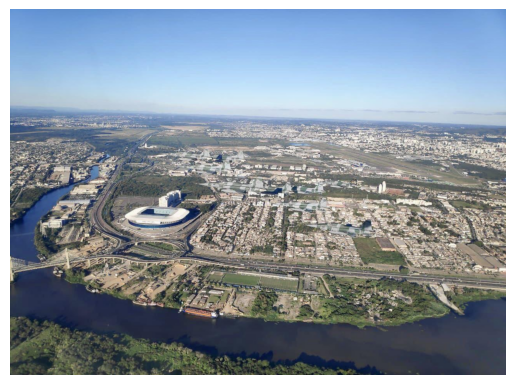

In [82]:
import matplotlib.pyplot as plt
from PIL import Image

# Load image
img = Image.open("./examples/fighter_jets.jpg")

# Show image
plt.imshow(img)
plt.axis("off")   # hide axes
plt.show()

In [210]:
pixel_values = load_image_from_url_no_db('https://image.cnbcfm.com/api/v1/image/107196244-1676618256129-An_Li.jpg?v=1676635561&w=1260&h=709&ffmt=webp&vtcrop=y', max_num=12).to(torch.bfloat16).cuda()


In [136]:
import hashlib

def sha256_bytes(data: bytes) -> str:
    return hashlib.sha256(data).hexdigest()


def phash(img: Image.Image, hash_size: int = 8) -> str:
    """
    Perceptual hash (pHash) implementation using DCT.
    Returns a hex string. Good for near-duplicate detection.
    """

    img = normalize_image_for_hash(img).convert("L")  # grayscale
    # pHash uses a larger resize than hash_size; common is 32x32
    img = img.resize((32, 32), Image.Resampling.LANCZOS)

    pixels = np.asarray(img, dtype=np.float32)

    # 2D DCT
    # implement DCT via scipy if available; otherwise use numpy FFT trick fallback
    try:
        from scipy.fftpack import dct
        dct_rows = dct(pixels, axis=0, norm="ortho")
        dct_2d = dct(dct_rows, axis=1, norm="ortho")
    except Exception:
        # fallback: slower/rougher but works without scipy
        import numpy.fft as fft
        dct_2d = fft.fft2(pixels).real

    # take top-left 8x8 (excluding DC term optionally)
    dct_lowfreq = dct_2d[:hash_size, :hash_size]
    # median excluding DC for stability
    dct_flat = dct_lowfreq.flatten()
    med = float(np.median(dct_flat[1:]))

    bits = (dct_lowfreq > med).astype(np.uint8).flatten()
    # pack bits into hex
    bit_string = "".join("1" if b else "0" for b in bits)
    return hex(int(bit_string, 2))[2:].zfill((hash_size * hash_size + 3) // 4)
    

def hamming_distance_hex(h1: str, h2: str) -> int:
    """
    Hamming distance between two equal-length hex hashes (e.g., pHash hex strings).
    """
    if len(h1) != len(h2):
        raise ValueError("Hashes must be same length")
    b1 = bin(int(h1, 16))[2:].zfill(len(h1) * 4)
    b2 = bin(int(h2, 16))[2:].zfill(len(h2) * 4)
    return sum(c1 != c2 for c1, c2 in zip(b1, b2))




def normalize_image_for_hash(img: Image.Image) -> Image.Image:
    """
    Normalize to a stable format before perceptual hash:
    - convert to RGB
    - handle weird modes (P, LA, RGBA, etc.)
    """
    if img.mode not in ("RGB", "L"):
        img = img.convert("RGB")
    return img
    


def hash_image(img: Image.Image):
    data = img.tobytes()
    sha = sha256_bytes(data)
    p = phash(img)
    return {
        "sha256": sha,
        "phash": p,
        "content_length": len(data)
    }

In [239]:
image_url = "https://image.cnbcfm.com/api/v1/image/107196238-1676617601203-Eric_Esterle.jpg?v=1676635561"
headers = {
    "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7)"}
    
response = requests.get(image_url, headers=headers)
#print(response.content)
img = Image.open(BytesIO(response.content))


type(img)

hash_image(img)

print(img)
print(img.width)
print(img.height)
print(img.format)
print(len(img.tobytes()))

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=6859x4573 at 0x7D4E2B2FBB20>
6859
4573
JPEG
94098621


In [227]:
def prompt_from_url(image_url, question="Please describe the image in as much detail as possible"):
    question = '<image>\n'+ question



    img = db_image_load(image_url)

    pixel_values = create_pixel_values(img, max_num=12).to(torch.bfloat16).cuda()
    

    response = model.chat(tokenizer, pixel_values, question, generation_config)
    print(f'User: {question}\nAssistant: {response}')

    # Show image
    plt.imshow(img)
    plt.axis("off")   # hide axes
    plt.show()
    return response


In [228]:
def feedback_from_url(image_url, question="Please describe the image in as much detail as possible"):

    response = prompt_from_url(image_url, question=question)
    feedback = input("Press enter if you approve of the response otherwise provided informative feedback")
    return response, feedback
    

In [212]:
def prompt_from_path(image_path, question="Please describe the image in as much detail as possible"):
    question = '<image>\n'+ question
    img = Image.open(image_path)

    pixel_values = load_image_no_db(image_path, max_num=12).to(torch.bfloat16).cuda()

    response = model.chat(tokenizer, pixel_values, question, generation_config)
    print(f'User: {question}\nAssistant: {response}')

    # Show image
    plt.imshow(img)
    plt.axis("off")   # hide axes
    plt.show()


User: <image>
Please describe the image in as much detail as possible
Assistant: The image shows a marching band performing on a football field. The band members are arranged in a circular formation, creating a visually striking pattern. They are wearing uniforms with white and orange colors, and some members are holding flags or banners. The field is marked with yard lines and numbers, typical of a football stadium. In the background, there is a large crowd of spectators in the stands. The text overlay on the image reads "PRIDE OF THE SOUTHLAND BAND PREPPING FOR GAME."


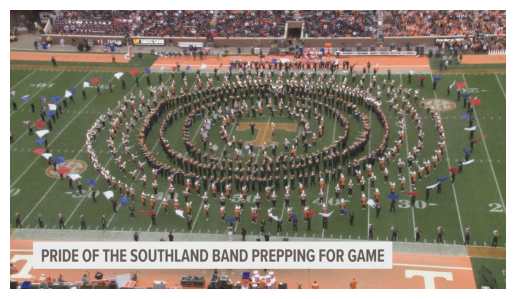

Press enter if you approve of the response otherwise provided informative feedback circles are concentric. Multiple circles of increasing size. There is also a large orange T in the center of the field.


status 200
response {'id': 14, 'feedback': 'circles are concentric. Multiple circles of increasing size. There is also a large orange T in the center of the field.'}


In [264]:
update_db_with_feedback("https://media.wbir.com/assets/WBIR/images/c1c57015-cbf1-4340-bb7c-f35a3496188c/20241218T221656/c1c57015-cbf1-4340-bb7c-f35a3496188c_1920x1080.jpg")

User: <image>
Please describe the image in as much detail as possible
Assistant: The image depicts a vast, intricate landscape of terraced fields, likely salt pans, carved into the side of a mountain. The fields are divided into rectangular sections, with water-filled basins creating a patterned effect. The terrain is rugged and steep, with the fields extending into the distance, bordered by towering mountains. The sky is overcast, casting a soft, diffused light over the scene. A solitary figure is visible, walking along the edge of one of the terraces, adding a sense of scale to the immense size of the landscape. The overall color palette is monochromatic, with varying shades of gray that emphasize the textures and contours of the natural environment.


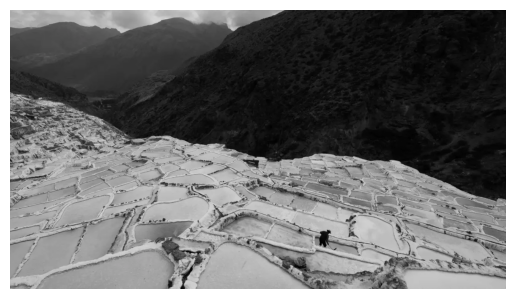

In [86]:
prompt_from_url("https://image.cnbcfm.com/api/v1/image/107196244-1676618256129-An_Li.jpg?v=1676635561&w=1260&h=709&ffmt=webp&vtcrop=y")

User: <image>
How would you describe the positioning and pose of the horse
Assistant: The horse is in mid-jump over a small stream, with its front legs extended forward and its hind legs tucked up behind it. The horse's head is held high, and it appears to be in a dynamic pose, suggesting movement and energy.


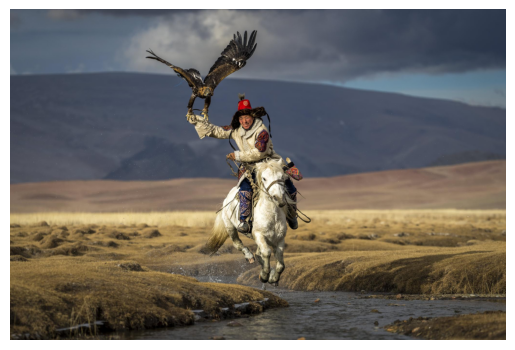

Press enter if you approve of the response otherwise provided informative feedback Front legs are curled back and rear legs are tuck upwards not behind.


status 200
response {'id': 15, 'feedback': 'Front legs are curled back and rear legs are tuck upwards not behind.'}


In [266]:
update_db_with_feedback("https://image.cnbcfm.com/api/v1/image/107196238-1676617601203-Eric_Esterle.jpg?v=1676635561",
               "How would you describe the positioning and pose of the horse")


In [189]:
feedback = feedback_from_url(
    "https://substackcdn.com/image/fetch/$s_!3hGr!,f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2F53b40458-0193-4299-a621-82598ae23fce_1080x1350.jpeg",
    "please only describe the upper left quadrant of this image")


AttributeError: 'Image' object has no attribute 'to'

In [100]:
saved_feedback='The upper left quadrant of this does not feature a purple posing suit, it contains the upper torso of an extremely fit man of likely Black/african ethnic origins. He has a sizeable tattoo on his arm but the details are difficult to make out. The subject also has a very short haircut with dark brown hair. The hairstyle is often called a fade.'

In [ ]:
question="please only describe the upper left quadrant of this image"
user_id=1
model_name="InternVL2_5-2B"
model_type="vlm"
task="open"3


In [174]:
import requests

url = "http://127.0.0.1:8000/convos"

image_path = "https://substackcdn.com/image/fetch/$s_!3hGr!,f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2F53b40458-0193-4299-a621-82598ae23fce_1080x1350.jpeg"

convo = [
    {"from":"human", "value": f"<image>\n{question}"},
    {"from":"gpt", "value": response}
]

convo_entry = dict(
    user_id=user_id,
    image=image_path,
    model_name=model_name,
    model_type=model_type,
    task=task,
    conversations=convo,
    feedback=saved_feedback
)

resp = requests.post(url, json=convo_entry)

In [175]:
print("status", resp.status_code)
print("response", resp.json())

status 200
response {'id': 7, 'feedback': 'The upper left quadrant of this does not feature a purple posing suit, it contains the upper torso of an extremely fit man of likely Black/african ethnic origins. He has a sizeable tattoo on his arm but the details are difficult to make out. The subject also has a very short haircut with dark brown hair. The hairstyle is often called a fade.'}


In [101]:
len(feedback)

343

In [53]:
img = Image.open("../../local_datasets/IMG_4407.jpg")
plt.imshow(img)
plt.axis("off")   # hide axes
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '../../local_datasets/IMG_4407.jpg'

In [54]:
prompt_from_path("../../local_datasets/IMG_4407.jpg", "What type of plants are visible, be specific?"
                )


FileNotFoundError: [Errno 2] No such file or directory: '../../local_datasets/IMG_4407.jpg'

/home/ubuntu/anaconda3/envs/sandbox/lib/python3.10/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


User: <image>
Estimate how many roses are in the image
Assistant: The image shows a large bouquet of red roses, but it's challenging to provide an exact count due to the clustering and overlapping of the flowers. Estimating from the visible parts, there appear to be around 50-60 roses in the bouquet. This is a subjective estimate and could vary.


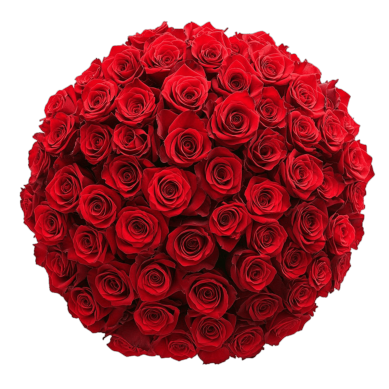

In [92]:
prompt_from_url(
    "https://cdn.globalrose.com/assets/img/prod/red-roses-for-valentines-day-globalrose.png",
    "Estimate how many roses are in the image")